# TP 4 - Learning on LOBs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## 0. Récupération des données

On adapte la fonction du TP3 pour rajouter certains attributs qui nous seront utiles dans la suite du TP.

In [2]:
def get_data(data_folder_path, assets):

    if not os.path.exists(data_folder_path):
        print("Le dossier n'est pas trouvable à l'adresse suivante", data_folder_path)

    else:
        
        dico_data = {asset: None for asset in assets}

        for filename in os.listdir(data_folder_path):
            if filename[:-3] in dico_data:
                file_path = os.path.join(data_folder_path, filename)

                df_loc = pd.read_hdf(file_path)
                bq, aq = df_loc.BidQty.to_numpy(), df_loc.AskQty.to_numpy() 
                df_loc['mid'] = (df_loc['AskPrice'] + df_loc['BidPrice']) / 2
                df_loc['imb'] = (aq - bq) / (aq + bq)
                df_loc['round_imb'] = np.around(df_loc.imb.to_numpy(), 1)
                dico_data[filename[:-3]] = df_loc
    
    return dico_data

## 1. Pouvoir prédictif de l'imbalance sur les mouvements de prix futurs

Choisissez un des 10 actifs et utilisez l'intégralité de la base de données (l'année 2011).

Calculez l'imbalance signée sur votre base de donnée.

$$\text{Imb} = \frac{Q_{ask}-Q_{bid}}{Q_{ask}+Q_{bid}}$$

Calculer pour divers horizons $h$ (entre 1 et 10 par exemple) la différence entre le prix courant et le prix futur à horizon $h$ en point de base (bps).

$$\text{diff}(h)=100\times100\times\frac{P_{t+h}-P_t}{P_t}$$

En déduire le pouvoir prédictif de l'imbalance sur $\text{diff}(h)$ en fonction des différentes valeurs de $h$ (régression). Vous pourrez arrondir l'imbalance à $10^{-1}$ et regrouper (`groupby`) les mouvements de prix pour un horizon $h$ donné en fonction de la valeur de l'imbalance. 

Etudier la relation pour les différents horizons $h$ considérés. Commenter vos résultats.

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_folder_path = os.path.join(parent_directory, 'Stock Data') # nom du dossier contenant les données à la racine.

assets = ['AMAZON', 'APPLE', 'BOUYGUES',  'CANON', 'GOOGLE', 'LVMH', 'NISSAN', 'PANASONIC', 'SANOFI', 'SONY', 'TOTAL']

dico_data = get_data(data_folder_path, assets)

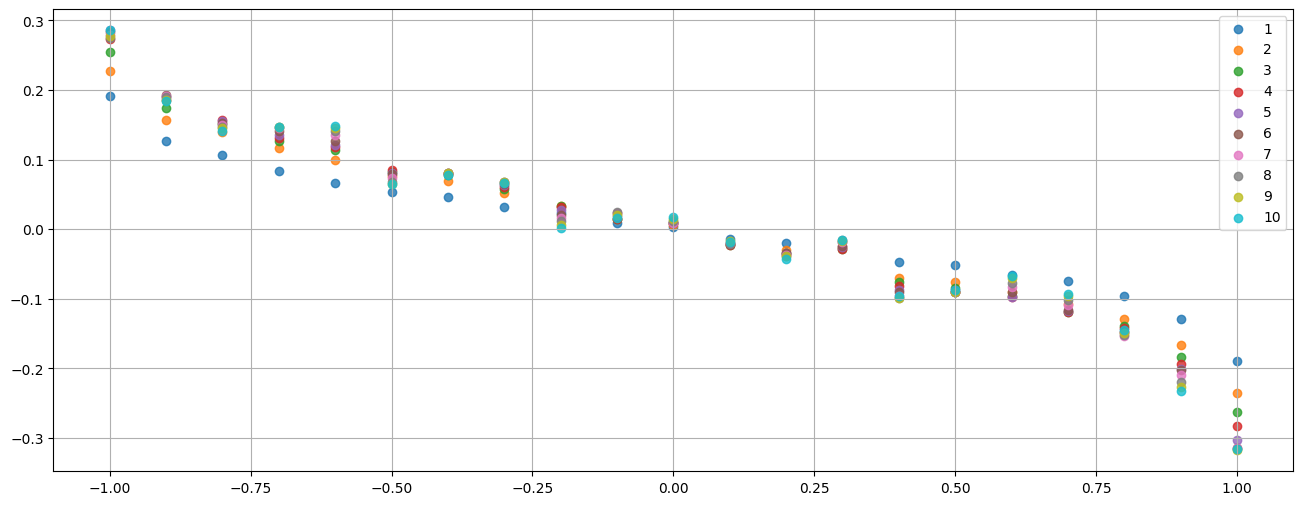

In [4]:
df = dico_data['TOTAL']
list_h = [1 + i for i in range(10)]
arr_price = df.TradedPrice.to_numpy()
plt.figure(figsize = (16, 6))
for h in list_h:
    df_lim = df.iloc[:-h].copy()
    df_lim['diff'] = 1e4 * (arr_price[h:] - arr_price[:-h]) / arr_price[:-h]
    series = df_lim.groupby(['round_imb'])['diff'].mean()
    plt.scatter(series.index.to_numpy(), series.to_numpy(), alpha = 0.8, label = h)
plt.legend()
plt.grid(axis = 'both')
plt.show()

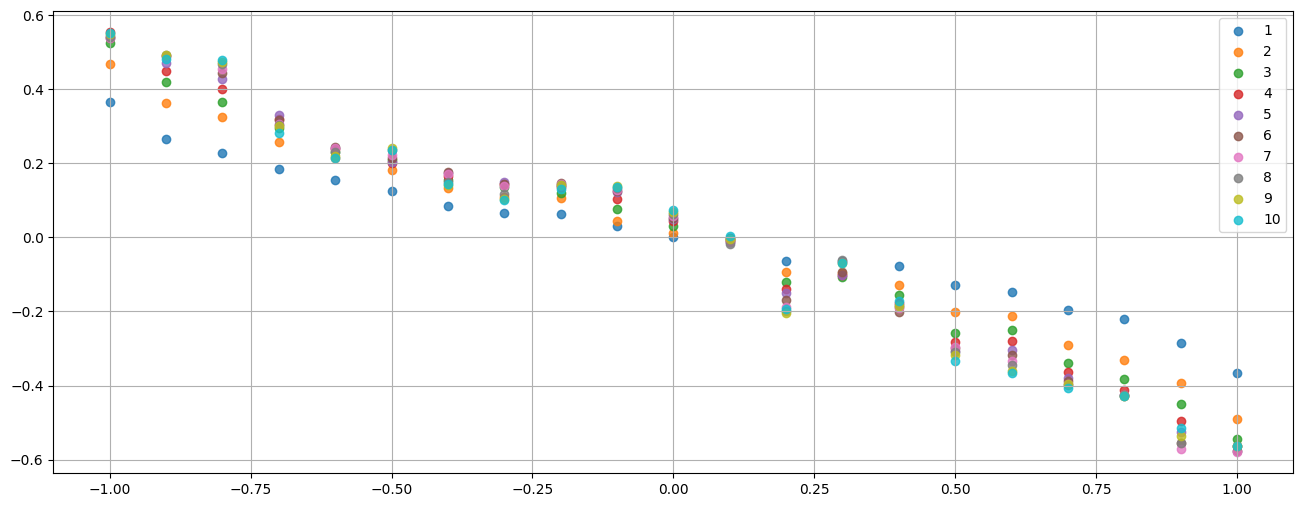

In [5]:
df = dico_data['BOUYGUES']
list_h = [1 + i for i in range(10)]
arr_price = df.TradedPrice.to_numpy()
plt.figure(figsize = (16, 6))
for h in list_h:
    df_lim = df.iloc[:-h].copy()
    df_lim['diff'] = 1e4 * (arr_price[h:] - arr_price[:-h]) / arr_price[:-h]
    series = df_lim.groupby(['round_imb'])['diff'].mean()
    plt.scatter(series.index.to_numpy(), series.to_numpy(), alpha = 0.8, label = h)
plt.legend()
plt.grid(axis = 'both')
plt.show()

On constate que l'imbalance a un réel pouvoir prédictif, notamment on observe une relation linéaire (voire une dépendance cubique en $x \mapsto -x^3$) et ce quelle que soit l'horizon $h$. Nous détaillerons cela dans les résultats de la partie suivante.

## 2. Améliorer le résultats précédent à l'aide de réseaux de neurones et de mémoire sur les signes des transactions

Ajouter comme variables :
* le signe des 10 dernières transactions (`TradedSign`), 
* le volume des transactions renormalisé par l'ATS (Average Trading Size), 
* les volumes aux bests bid et ask.

On va chercher à prédire à partir de ses signes des 10 dernières transactions, des volumes aux best bid et best ask, du volume de la transaction renormalisé et de l'imbalance, l'accroissement futur ($\text{diff}(h)$) du prix à l'aide d'un MLP (MutliLayer Perceptron) en utilisant `tensorflow`.

### a. Installer TensorFlow

In [6]:
import keras
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

2024-04-09 18:01:46.102484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### b. Créer un jeu d'entraîement et un jeu de test pour le modèle

Centrer et standardiser les variables et créer votre jeu d'entraînement et votre jeu de test.

In [7]:
def get_train_test_data(stock: str, 
                        h: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    df = dico_data[stock]

    imb = df.imb.to_numpy()[10:-h]
    volume = df.TradedQty.to_numpy()[10:-h]
    bq, aq = df.BidQty.to_numpy()[10:-h], df.AskQty.to_numpy()[10:-h]
    bp, ap = df.BidPrice.to_numpy()[10:-h], df.AskPrice.to_numpy()[10:-h]
    signs = [df.TradedSign.to_numpy()[i:i - h - 10] for i in range(10)]
    X = np.array([imb, volume, bq, aq, bp, ap] + signs)

    arr_price = df.TradedPrice.to_numpy()[10:]
    y = 1e4*(arr_price[h:] - arr_price[:-h]) / arr_price[:-h]

    scaler = preprocessing.StandardScaler().fit(X.T)
    X_scaled = scaler.transform(X.T).T

    X_train, X_test, y_train, y_test = train_test_split(X_scaled.T, y, test_size=0.1)

    return(X_train, X_test, y_train, y_test)

In [8]:
X_train, X_test, y_train, y_test = get_train_test_data(stock='TOTAL', h=1)

### c. Construire le réseaux de neurones

Construire le réseau de neurones. Vous pourrez commencer avec un basique (une couche d'entrée et une de sortie) pour voir les résultats, puis ajouter au fur et à mesure des couches cachées pour améliorer les résultats.

Vous pouvez utiliser l'API séquentielle de Keras : le modèle est défini avec la commande `keras.models.Sequential()` et les couches denses avec `keras.layers.Dense()`.

In [9]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(shape=(16,)),
        keras.layers.Dense(32, activation="relu", name="layer1"),
        keras.layers.Dense(1, activation="relu", name="output_layer"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577 (2.25 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

Compiler le modèle. Vous pouvez utiliser l'optimiseur `SGD` et l'erreur quadratique moyenne comme fonction de perte.

In [10]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
)

On rajoute notamment un scheduler pour réduire la taille du learning rate au fur et à mesure.

In [11]:
def learning_rate_scheduler(epoch, lr):
    
    if epoch%2 == 0 and epoch:
        return lr*0.1
    return lr

In [12]:
scheduler = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

### d. Entraîner votre modèle sur le jeu d'entraînement

In [13]:
model.fit(
    x = X_train,
    y = y_train,
    batch_size = 1024,
    epochs = 5,
    callbacks=[scheduler]
);

Epoch 1/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.5042 - learning_rate: 0.0010
Epoch 2/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.7158 - learning_rate: 0.0010
Epoch 3/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.6157 - learning_rate: 1.0000e-04
Epoch 4/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.8096 - learning_rate: 1.0000e-04
Epoch 5/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.7960 - learning_rate: 1.0000e-05


### e. Evaluer votre modèle sur le jeu d'entraînement

In [14]:
model.evaluate(x=X_train, y=y_train)

133865/133865 ━━━━━━━━━━━━━━━━━━━━ 98s 728us/step - loss: 2.7585


2.723616123199463

### f. Evaluer votre modèle sur le jeu de test

In [15]:
model.evaluate(x=X_test, y=y_test)

14874/14874 ━━━━━━━━━━━━━━━━━━━━ 11s 724us/step - loss: 2.5277


2.68516206741333

### g. Analyser de vos résultats

Regarder vos résultats pour différents horizons $h$ sur la prévisions de $\text{diff}(h)$ et les comparer avec les résultats de la section 1. en utilisant l'imbalance. Commenter.

Comment pourriez-vous améliorer ce résultat ?

Comparons les résultats obtenus des deux méthodes par régression linéaire de la première partie avec les résultats par MLP pour différentes valeurs de $h$

#### - Régression linéaire

In [16]:
list_h = [1 + i for i in range(10)]
lin_reg_test_results = []

for h in list_h:

    X_train, X_test, y_train, y_test = get_train_test_data(stock='TOTAL', h=h)
    X_train = X_train[:, 0].reshape(-1, 1)
    X_test = X_test[:, 0].reshape(-1, 1)
    
    reg = LinearRegression().fit(X_train, y_train)
    lin_reg_test_results.append(np.mean((reg.predict(X_test) - y_test)**2))

#### - MLP

In [17]:
def test_and_train_model(stock = 'TOTAL', h = 1):
    X_train, X_test, y_train, y_test = get_train_test_data(stock, h)

    model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-1),
    loss=keras.losses.MeanSquaredError(),
    )
    model.fit(
        x = X_train,
        y = y_train,
        batch_size = 1024,
        epochs = 5,
        callbacks=[scheduler]
    )

    test_result = model.evaluate(x=X_test, y=y_test)
    return test_result


def loop(stock = 'TOTAL', h_list = [1 + i for i in range(10)]):
    test_results = []
    for h in h_list:
        test_result = test_and_train_model(stock, h)
        test_results.append(test_result)
    return test_results

In [18]:
test_results = loop(h_list = [1, 5, 10])

Epoch 1/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.6209 - learning_rate: 0.1000
Epoch 2/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.6884 - learning_rate: 0.1000
Epoch 3/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.8389 - learning_rate: 0.0100
Epoch 4/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.5731 - learning_rate: 0.0100
Epoch 5/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.6309 - learning_rate: 1.0000e-03
14874/14874 ━━━━━━━━━━━━━━━━━━━━ 11s 725us/step - loss: 3.0145
Epoch 1/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 11.2162 - learning_rate: 0.1000
Epoch 2/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 11.0985 - learning_rate: 0.1000
Epoch 3/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 11.0743 - learning_rate: 0.0100
Epoch 4/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 11.1640 - learning_rate: 0.0100
Epoch 5/5
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 11.1291 - learning_rate: 1.0000e-03
1487

#### - Comparaison

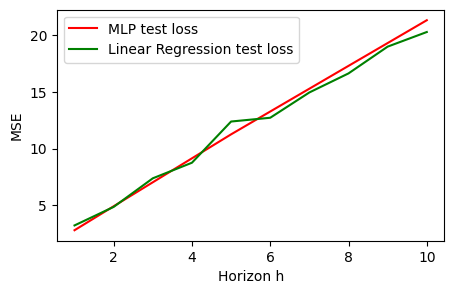

In [19]:
plt.figure(figsize=(5, 3))

plt.plot([1, 5, 10], test_results, label = 'MLP test loss', color = 'red')
plt.plot([1 + i for i in range(10)], lin_reg_test_results, label = 'Linear Regression test loss', color = 'green')

plt.xlabel('Horizon h')
plt.ylabel("MSE")
plt.legend()
plt.show()

On observe que l'amélioration lors du passage de la régression linéaire au MLP n'est pas significative.

Des axes d'amélioration éventuelles peuvent être : 

- un réglage plus précis des hyperparamètres de notre MLP (par validation croisée avec notamment un RandomizedSearchCV); notamment sur le nombre de couches, les fonctions d'activation, etc.

- la construction de nouvelles features ou la réduction du nombre de features (notamment le nombre des derniers signes à prendre en considération).